# Analysis of different initilaizations under the mean field scaling

The goal of this notebook is to study the impact of different initialization of multilayer fully-connected neural networks under the mean field scaling where layer outputs are divided by the number of units. For a network with layer sizes $(m_1, \ldots, m_{L-1})$ ($m_L=1$ since the we take the output of the network to be in $\mathbb{R}$), the output of the network with weights $\theta:=\left(w^l_{i,j}\right)_{l \in [L], i \in [m_l], j \in [m_{l-1}]}$ (with $m_0 = d+1$) is given :

- In the Mean Field (MF) scaling, by:
$$f(\theta; x) = \frac{1}{m_{L-1}} \sum_{i_{L-1}=1}^{m_{L-1}}w^L_{i_{L-1}} \sigma \left(\frac{1}{m_{L-2}} \sum_{i_{L-2}=1}^{m_{L-2}} w^{L-1}_{i_{L-1}, i_{L-2}} \sigma \left( \ldots \frac{1}{m_1} \sum_{i_1=1}^{m_1}w^2_{i_2, i_1}\sigma \left({w^1_{i_1}}^{T} x \right)  \right) \right)$$



- In the Neural Tangent Kernel (NTK) scaling, by
$$f(\theta; x) = \frac{1}{\sqrt{m_{L-1}}} \sum_{i_{L-1}=1}^{m_{L-1}}w^L_{i_{L-1}} \sigma \left(\frac{1}{\sqrt{m_{L-2}}} \sum_{i_{L-2}=1}^{m_{L-2}} w^{L-1}_{i_{L-1}, i_{L-2}} \sigma \left( \ldots \frac{1}{\sqrt{m_1}}\sum_{i_1=1}^{m_1}w^2_{i_2, i_1}\sigma \left({w^1_{i_1}}^{T} x \right)  \right) \right)$$

We want to study the distributions of the weights of the different layers, as well as each layer's output when the number of units $m_{l}$ in each layer go to infinity. We will discuss two different initialization strategies for each scaling (MF or NTK):
1. For each $l$, for any $m_l$, the weights $w^l$ of layer $l$ are intitialized i.i.d. using the same law $\rho_l$ over $\mathbb{R}$ which does **not** depend on $m_l$. In this case, for any $l$, for any $m_l, k_l$ and for any $i \in [m_l]$, $j \in [k_l]$, ${w^l_i}^{(m_l)}$ and ${w^l_j}^{(k_l)}$ are i.i.d.
2. For each $l$, for any $m_l$, the weights $w^l$ of layer $l$ are intitialized i.i.d. using a law $\rho^{(m_l)}_l$ over $\mathbb{R}$ which **can** potentially depend on $m_l$. In this case, for $k_l \neq m_l$  the weights of the $l$-th layer might be drawn from a different distribution when the width is $m_l$ than when the width is $k_l$.

Let us note that what is done in practice rather corresponds to the second case (e.g. Glorot initialization). To study the consequences on the network with large width of these different type of intialization we will use:
- for the first case, $\rho = \mathcal{U}[-1,1]$ or $\rho = \mathcal{N}(0, 1)$
- for the second case $\rho = $ Glorot uniform or $\rho = $ Glorot normal initialization. 
- We might try again the second case, and re-scale the init by $m_l$ or $\sqrt{m_l}$ since the MF scaling has reduced each layer's output. 

Note that the intialization law is **always centered** around 0, and this will matter for the discussion. To simplify the analysis, we will consider layers of equal size $m$ and $\sigma=$ ReLU, with $L$ = 2 or 3.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import math
import pandas as pd
import os

In [3]:
import sys
sys.path.insert(0, '/Users/karlhajjar/Documents/projects/wide-networks/')

from utils.plot.initialization.network import FCNetwork, define_networks, _rescale_init
from utils.plot.initialization.graphs import *
from utils.plot import set_plot_fonts

## Defining the constant variables for all the experiments

In [4]:
from pytorch.initializers import INIT_DICT
INIT_DICT

{'glorot_uniform': <function torch.nn.init.xavier_uniform_(tensor, gain=1.0)>,
 'glorot_normal': <function torch.nn.init.xavier_normal_(tensor, gain=1.0)>,
 'normal': <function torch.nn.init.normal_(tensor, mean=0.0, std=1.0)>,
 'uniform': <function torch.nn.init.uniform_(tensor, a=0.0, b=1.0)>}

In [5]:
sigma = nn.ReLU()
d = 100  # dimension of the input data
n = int(1e3)  # number of samples considered
Ms = [50, 100, 200, 500, 1000, 2000, 5000]  #, 10000 , 20000, 50000
n_trials = 20
L = 3
x = 2 * torch.rand((n,d))
# figsize = (14,8)
figsize = (11,8)

figures_dir = '/Users/karlhajjar/Documents/projects/wide-networks/figures/initialization/mf_vs_ntk_scaling/'

In [6]:
fonts_map = {'axes': {'titlesize': 20, 'labelsize': 18},
             'xtick': {'labelsize': 18},
             'ytick': {'labelsize': 18},
             'legend': {'fontsize': 16}}

set_plot_fonts(fonts_map)
sns.set_palette("deep")

In [7]:
def generate_outputs_plots(figsize, L, ms, d, init, init_params, n_trials, scaling, bias=False, scale_init=None,
                           save=True):
    
    template_figname = figname = '{}-{}-{{}}_vs_m'.format(init, scaling)
    if scale_init is not None:
        template_figname += '-' + scale_init
    template_figname += '.png'
    
    nets = define_networks(L, ms, d, init, init_params, n_trials, bias=bias, scaling=scaling, scale_init=scale_init)
    layers_outputs_df = get_layers_outputs_df(nets, inputs=x)
    
    title = 'Max absolute value of layers outputs vs m in the {} scaling'.format(scaling)
    plot_average_over_trials(layers_outputs_df, x='m', y='max absolute output', hue='layer', 
                             figsize=figsize, title=title)
    
    if save:
        figname = template_figname.format('all_layers_outputs')
        plt.savefig(os.path.join(figures_dir, figname))
    
    plt.show()
    print('\n\n')

    for l in range(L):
        layer_outputs_l = layers_outputs_df.loc[layers_outputs_df.layer == l+1, :]
        title = 'Max absolute value of layer {:,} outputs vs m in the {} scaling'.format(l+1, scaling)
        plot_average_over_trials(layer_outputs_l, x='m', y='max absolute output', figsize=figsize,
                                 title=title)
        
        if save:
            figname = template_figname.format('layer_{:,}_output'.format(l+1))
            plt.savefig(os.path.join(figures_dir, figname))
        
        plt.show()

In [8]:
def generate_gradients_plots(figsize, L, ms, d, init, init_params, n_trials, scaling, bias=False, scale_init=None, 
                             save=True):
    
    template_figname = figname = '{}-{}-{{}}_vs_m'.format(init, scaling)
    if scale_init is not None:
        template_figname += '-' + scale_init
    template_figname += '.png'
    
    nets = define_networks(L, ms, d, init, init_params, n_trials, bias=bias, scaling=scaling, scale_init=scale_init)
    layers_gradients_df = get_layers_gradients_df(nets, inputs=x)
    
    title = 'Max absolute value of layers gradients vs m in the {} scaling'.format(scaling)
    plot_average_over_trials(layers_gradients_df, x='m', y='max absolute derivative', hue='layer', 
                             figsize=figsize, title=title)
    
    if save:
        figname = template_figname.format('all_layers_gradients')
        plt.savefig(os.path.join(figures_dir, figname))
    
    plt.show()
    print('\n\n')

    for l in range(L):
        layer_gradients_l = layers_gradients_df.loc[layers_gradients_df.layer == l+1, :]
        title = 'Max absolute value of layer {:,} gradient vs m in the {} scaling'.format(l+1, scaling)
        plot_average_over_trials(layer_gradients_l, x='m', y='max absolute derivative', figsize=figsize,
                                 title=title)
        
        if save:
            figname = template_figname.format('layer_{:,}_gradient'.format(l+1))
            plt.savefig(os.path.join(figures_dir, figname))
    
        plt.show()

## Setting the seeds for reproducibility

In [9]:
def set_random_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [10]:
set_random_seeds()

## 1. Pure i.i.id. independent of layer size

### 1.1. Uniform initialization

In [11]:
init = 'uniform'
init_params = {'a': -2.0, 'b': 2.0}

#### 1.1.1 MF scaling

In [12]:
scaling = 'mf'

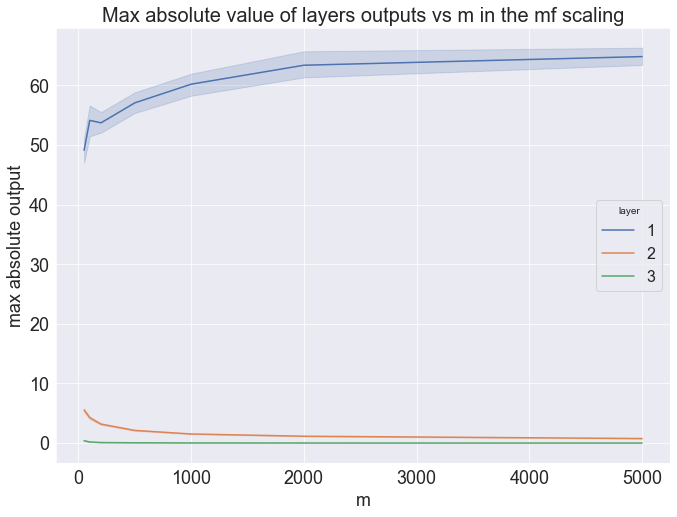

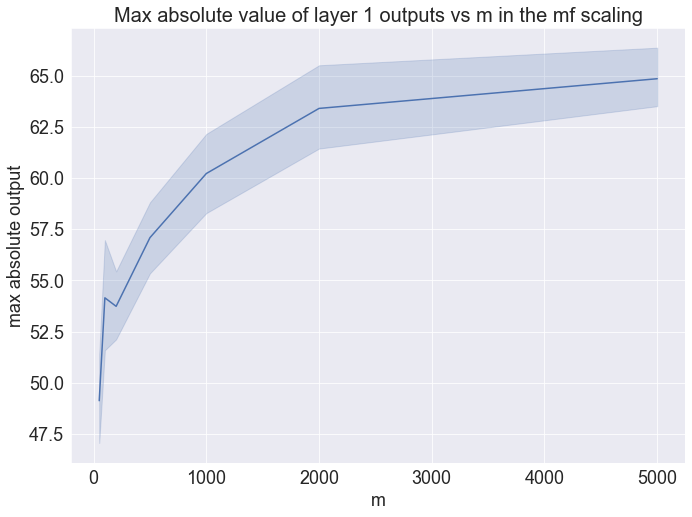

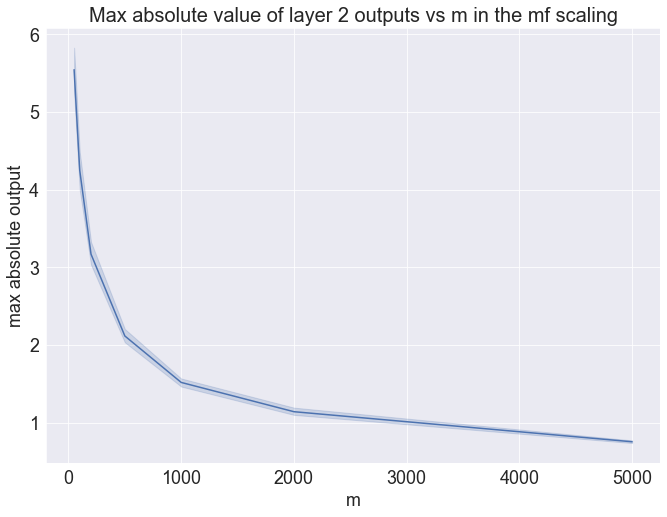

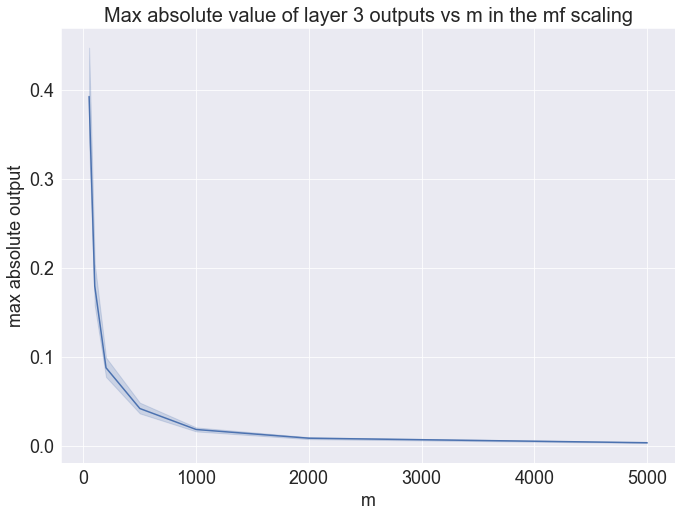

In [13]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 1.1.2 NTK scaling

In [14]:
scaling = 'ntk'

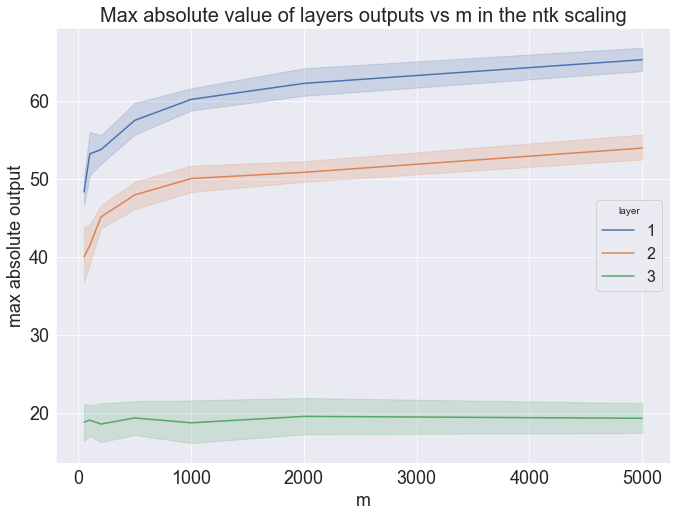

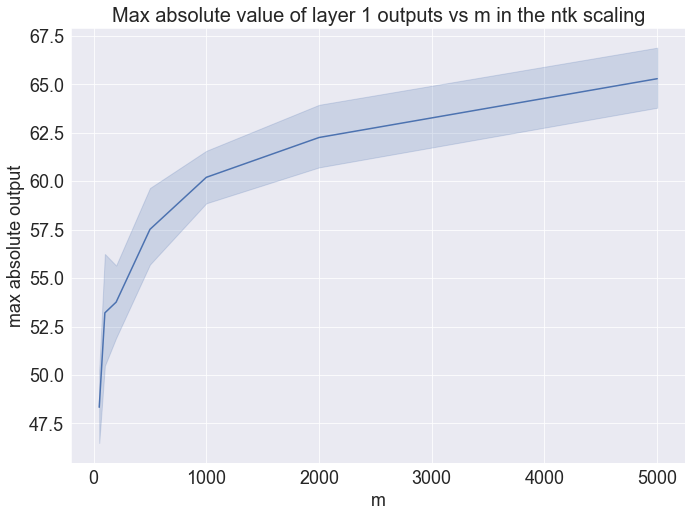

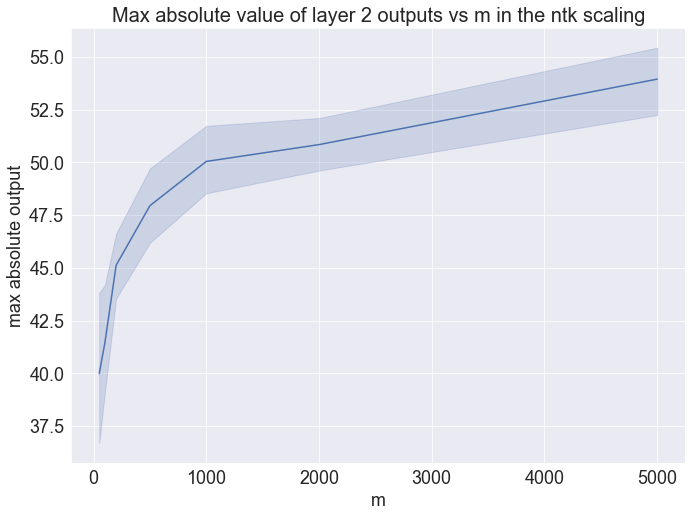

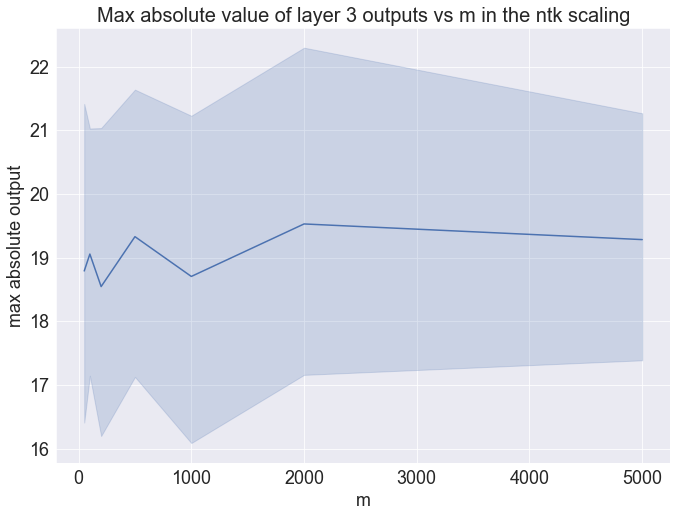

In [15]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

### 1.2. Normal initialization

In [16]:
init = 'normal'
init_params = {'mean': 0.0, 'std': 2.0}

#### 1.2.1 MF scaling

In [17]:
scaling = 'mf'

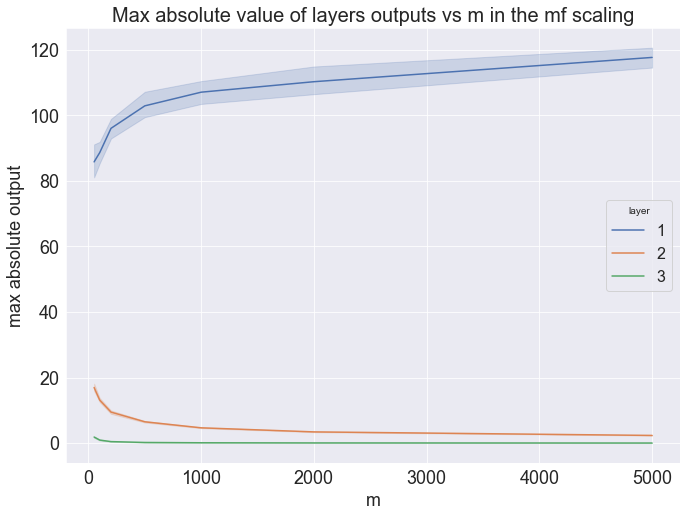

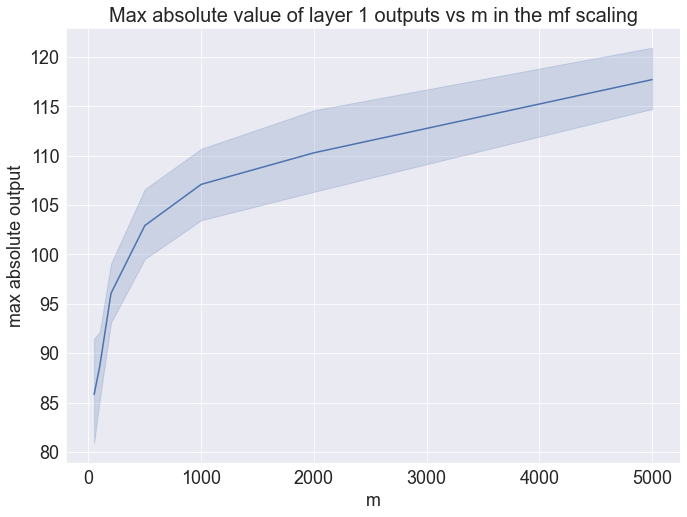

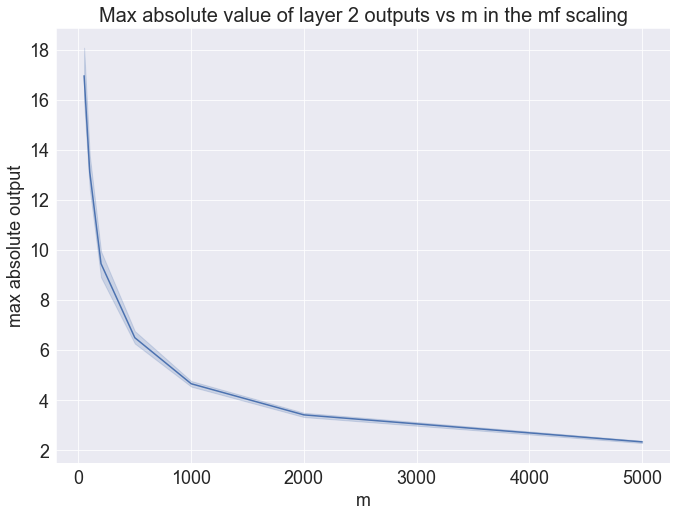

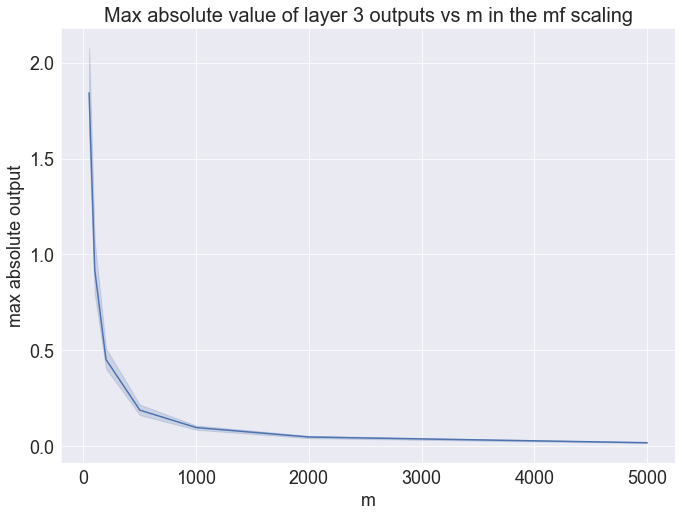

In [18]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 1.2.2 NTK scaling

In [19]:
scaling = 'ntk'

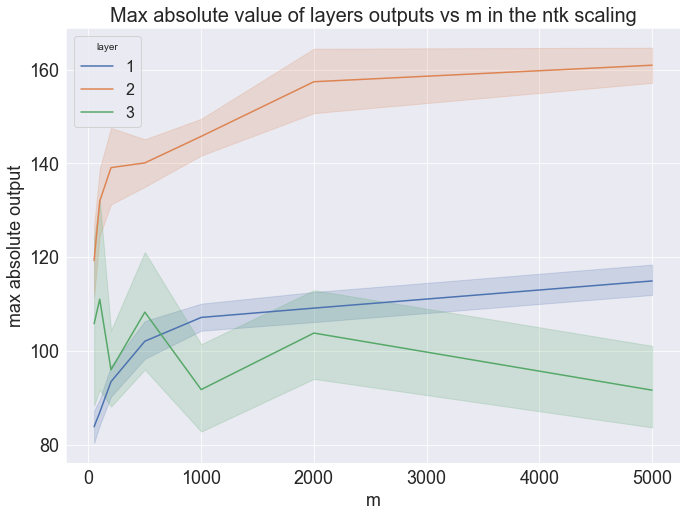

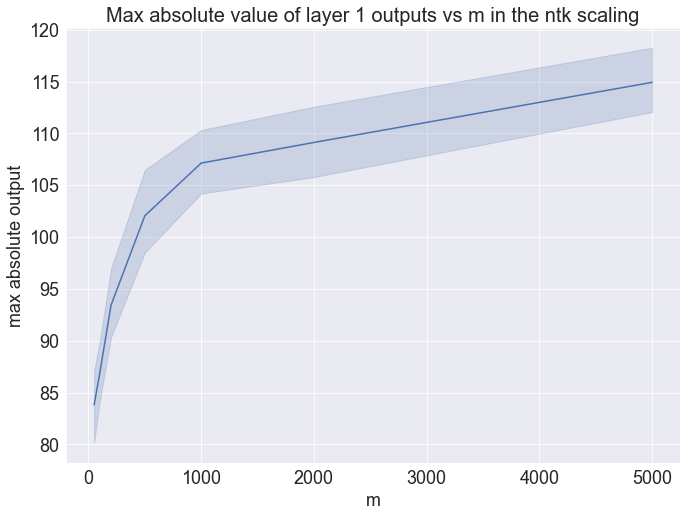

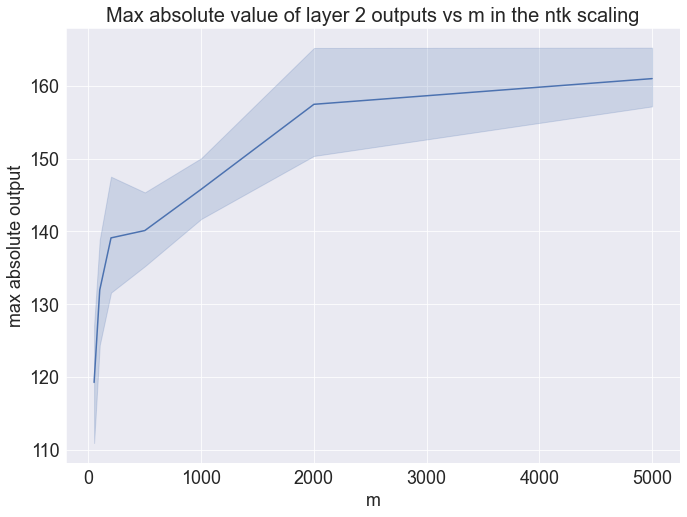

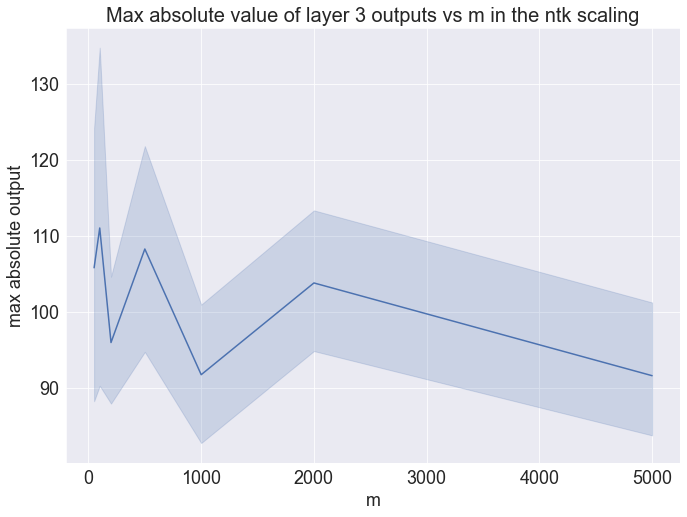

In [20]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

## 2. i.i.id. dependent of layer size with Glorot init

### 2.1. Glorot uniform initialization

In [21]:
init = 'glorot_uniform'
init_params = {'gain': 2.0}

#### 2.1.1 MF scaling

In [22]:
scaling = 'mf'

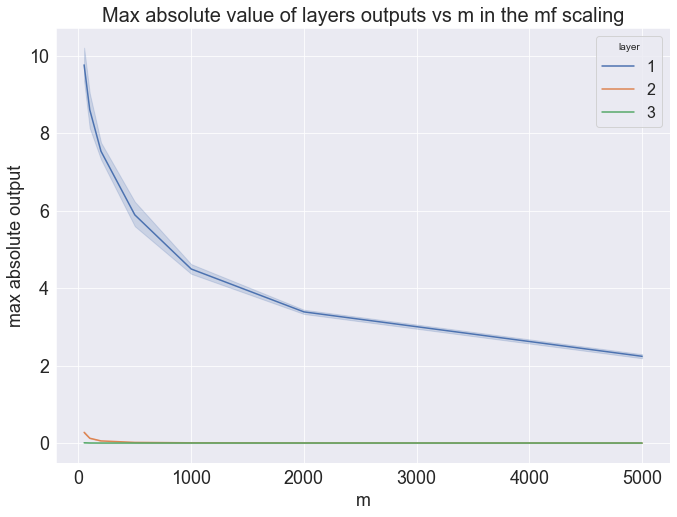

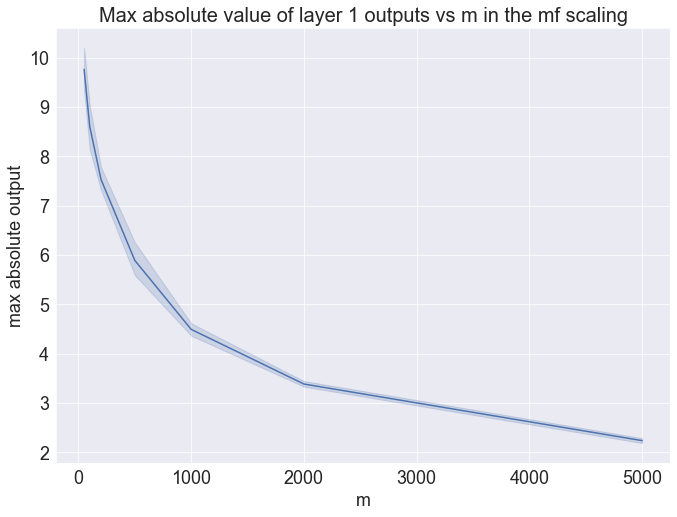

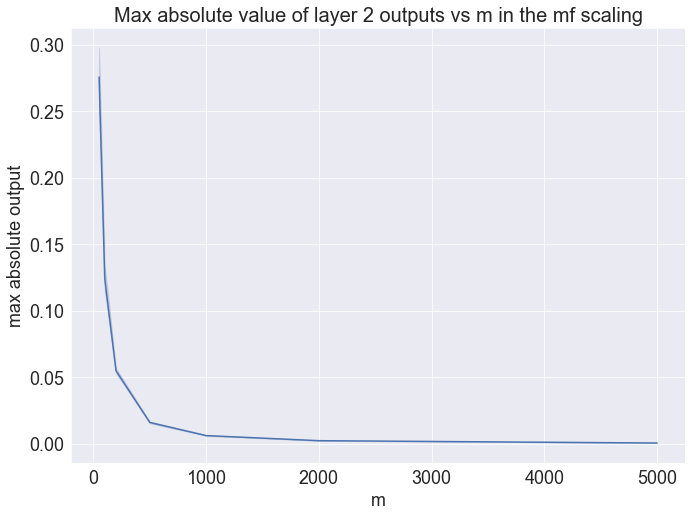

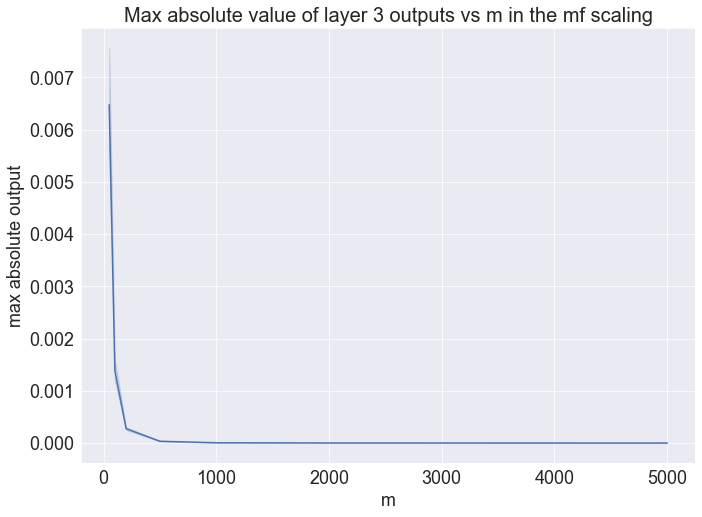

In [23]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 2.1.2 NTK scaling

In [24]:
scaling = 'ntk'

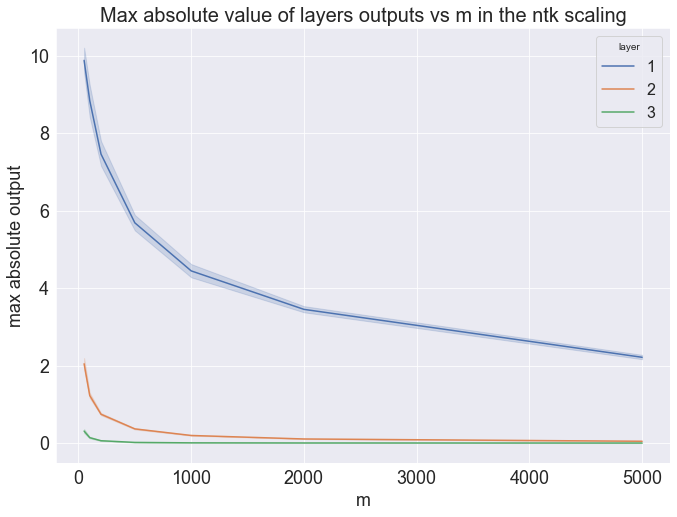

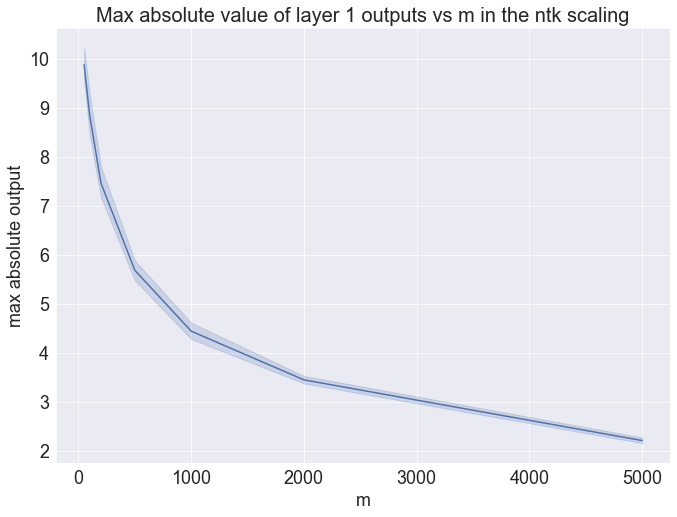

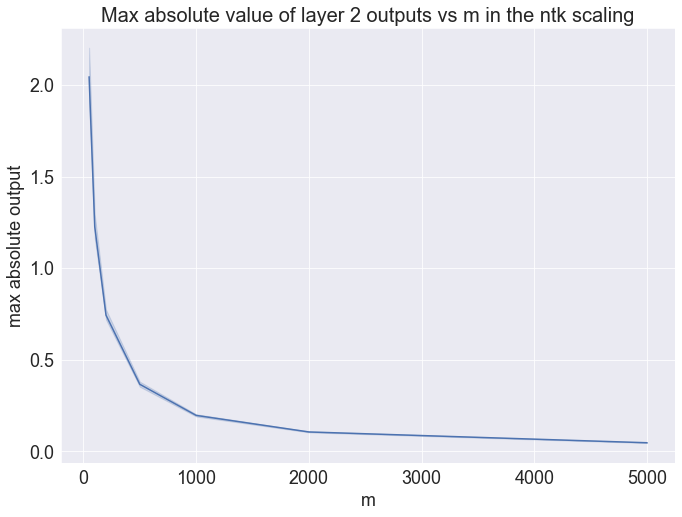

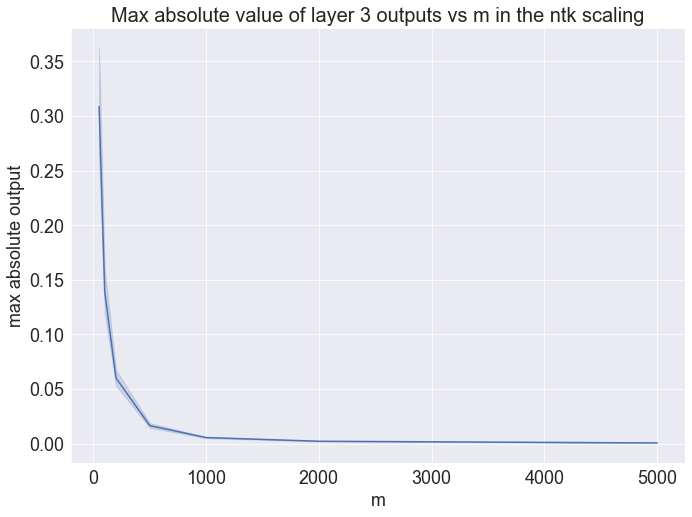

In [25]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

### 2.2. Glorot normal initialization

In [26]:
init = 'glorot_normal'
init_params = {'gain': 2.0}

#### 2.2.1 MF scaling

In [27]:
scaling = 'mf'

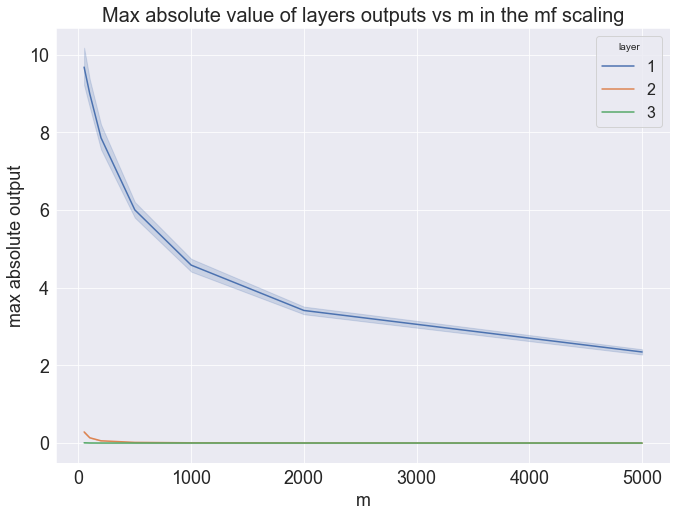

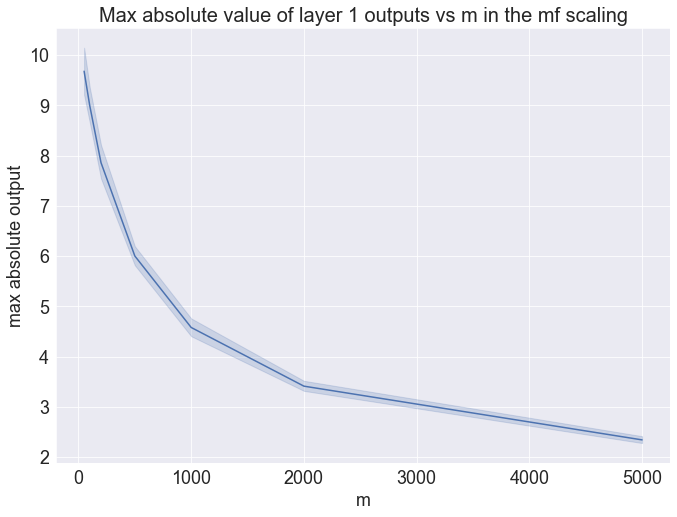

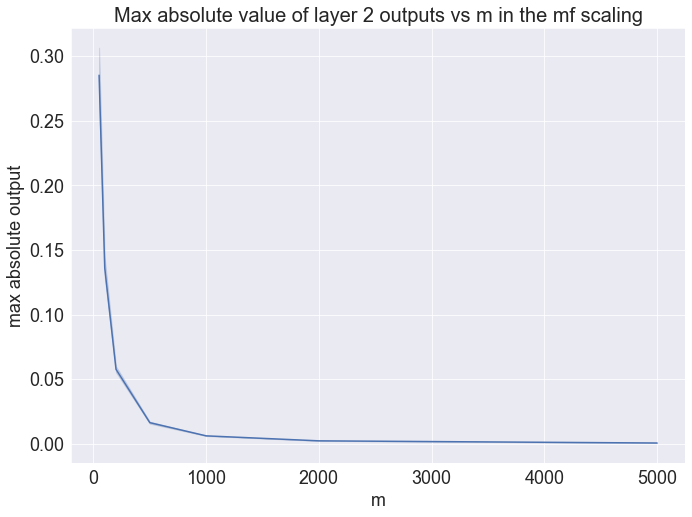

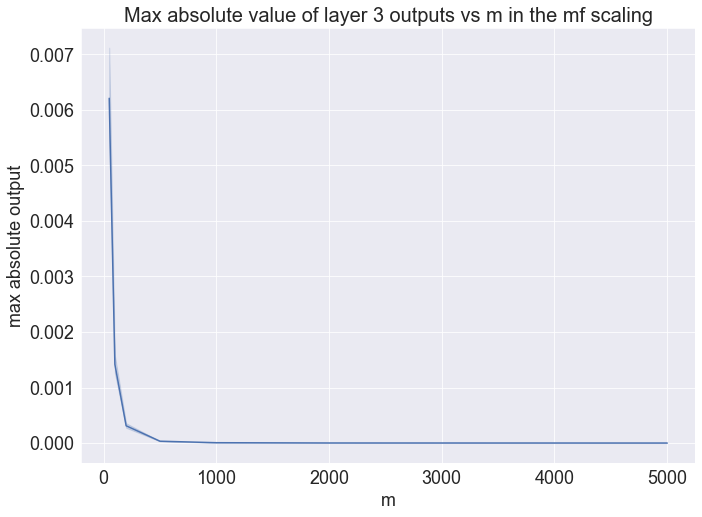

In [28]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 2.2.2 NTK scaling

In [29]:
scaling = 'ntk'

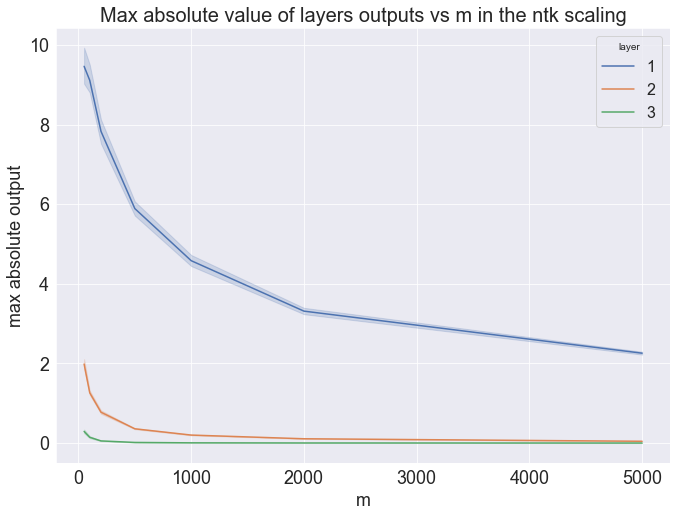

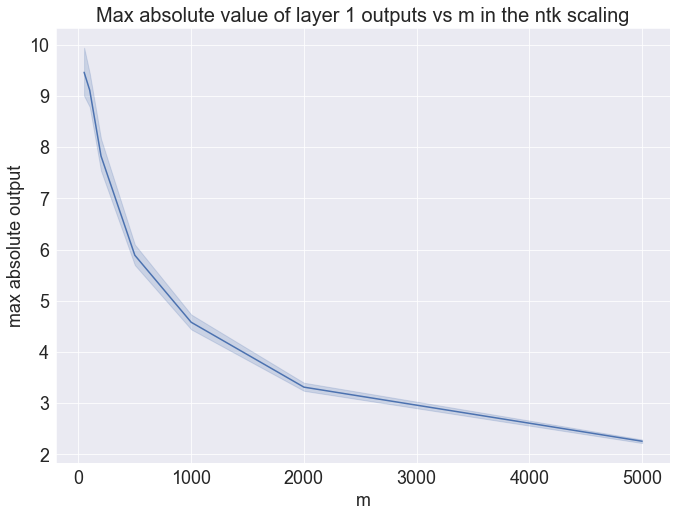

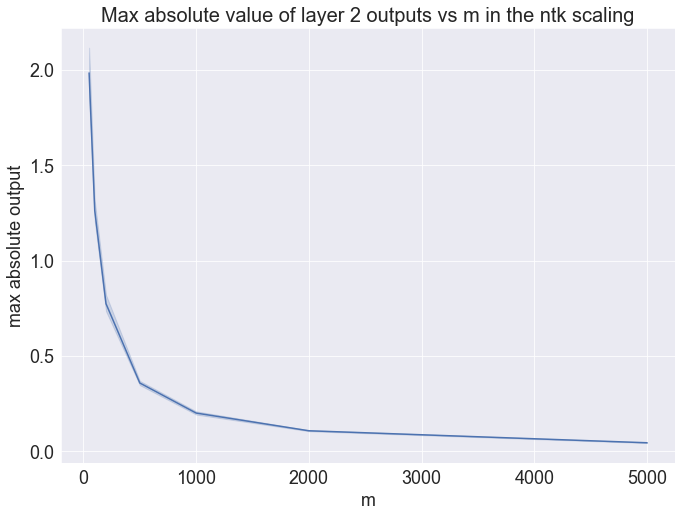

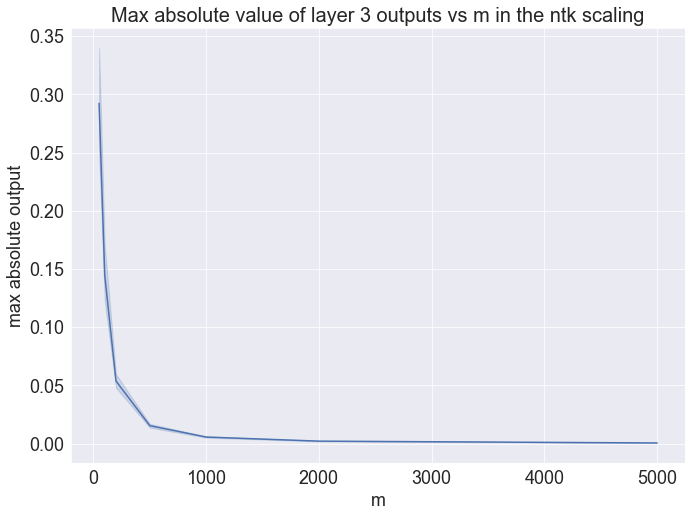

In [30]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

## 3. i.i.id. dependent of the layer size growing in $\sqrt{m}$

### 3.1. Uniform initialization

In [31]:
init = 'uniform'
init_params = {'a': -1, 'b': 1.0}

#### 3.1.1 MF scaling

In [32]:
scaling = 'mf'

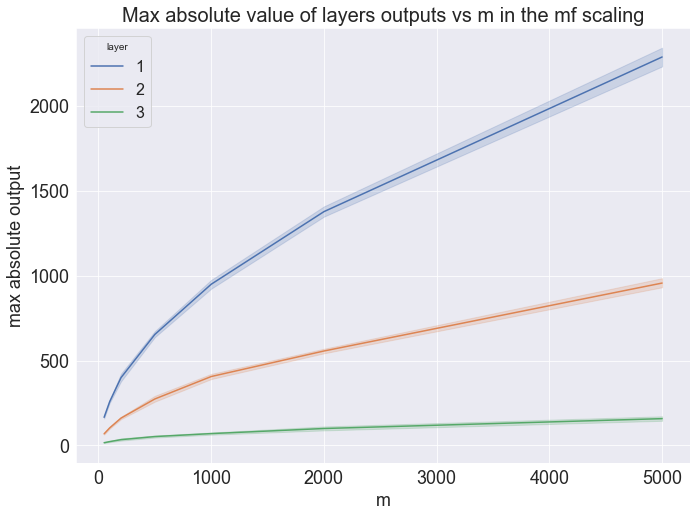

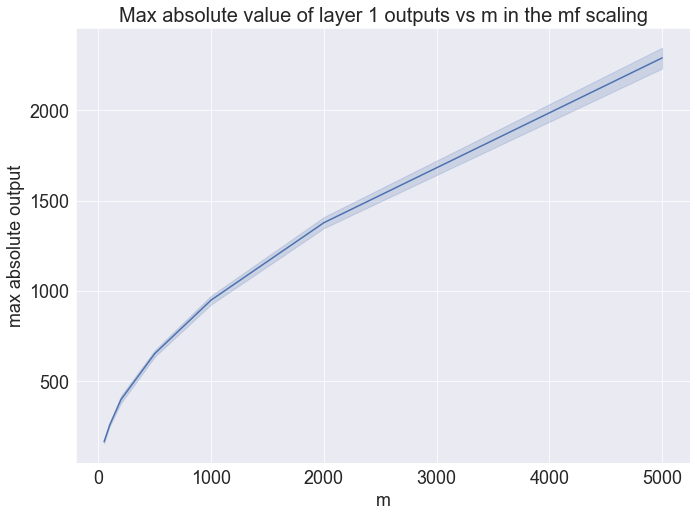

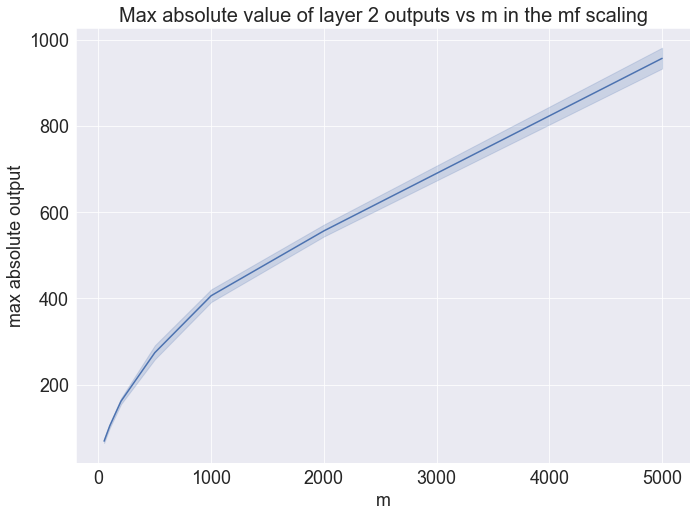

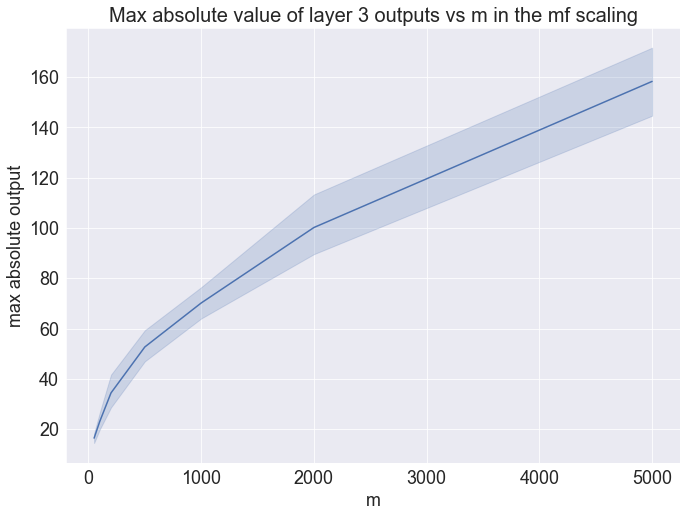

In [33]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init='sqrt')

### 3.2. Normal initialization

In [34]:
init = 'normal'
init_params = {'mean': 0.0, 'std': 2.0}

#### 3.2.1 MF scaling

In [35]:
scaling = 'mf'

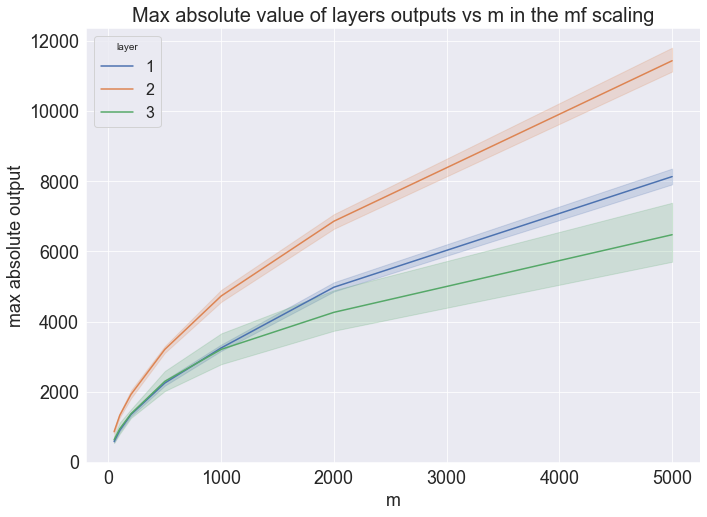

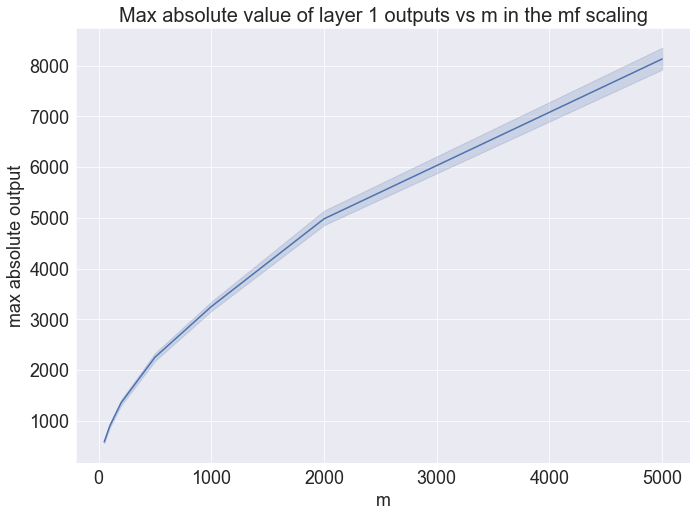

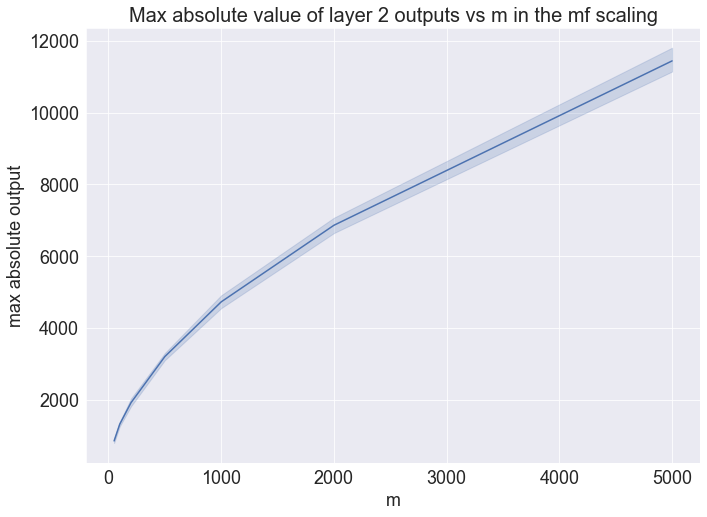

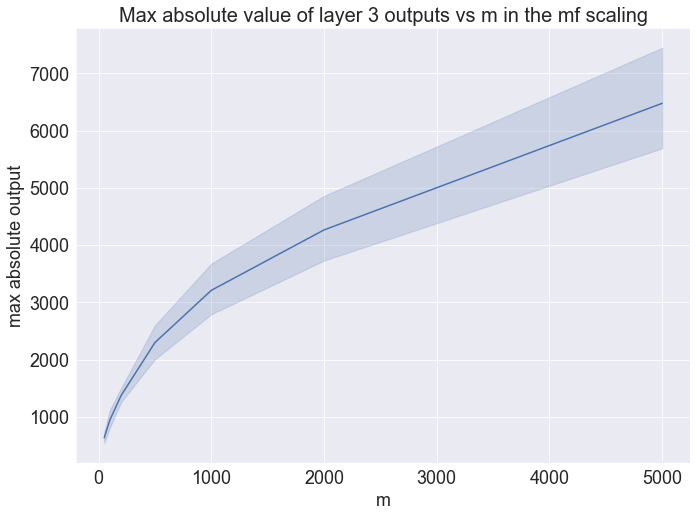

In [36]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init='sqrt')

## 4. i.i.id. dependent of layer size growing in $\sqrt{m}$ with Glorot type init

### 4.1. Glorot Uniform initialization

In [37]:
init = 'glorot_uniform'
init_params = {'gain': 1.0}

#### 4.1.1 MF scaling

In [38]:
scaling = 'mf'

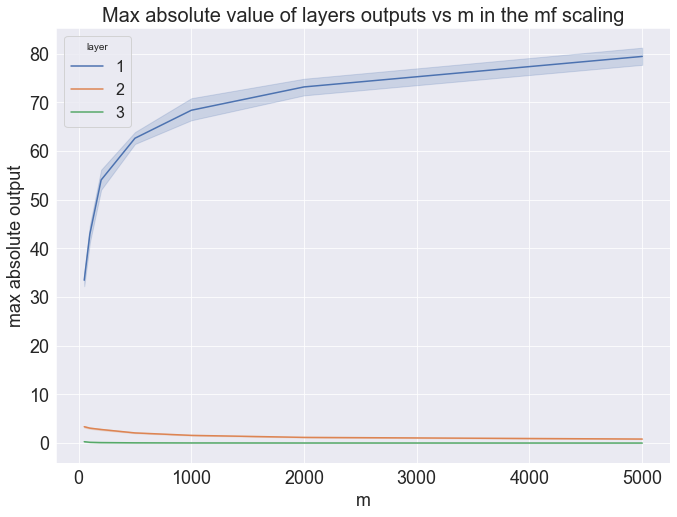

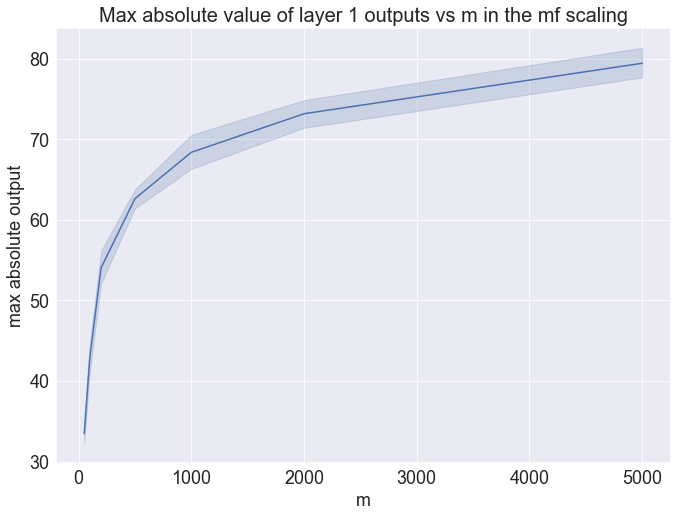

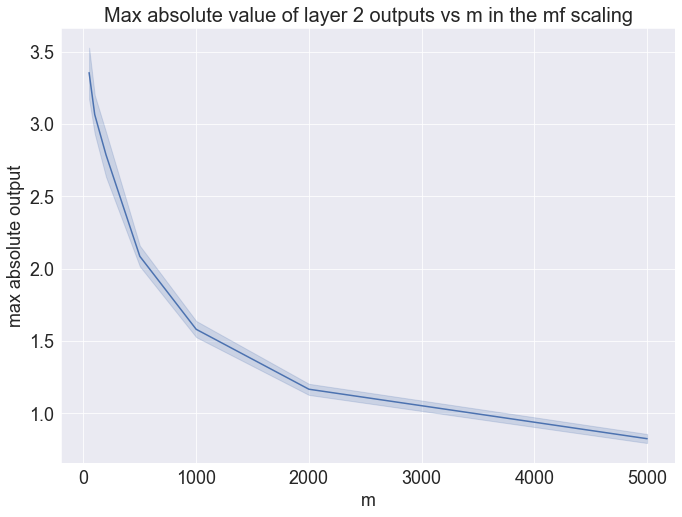

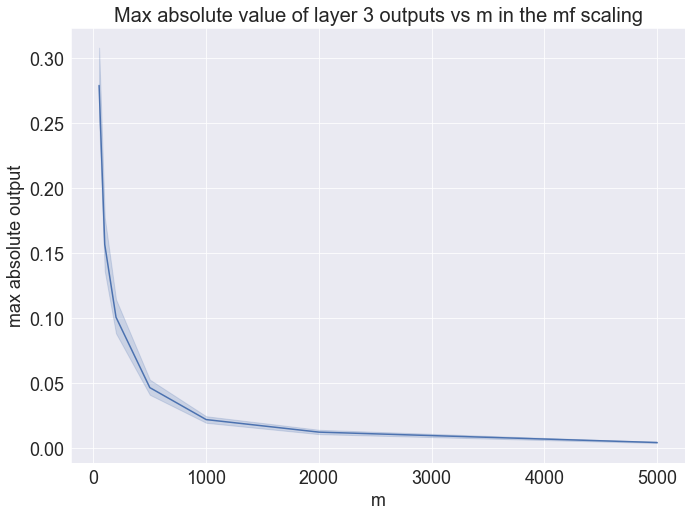

In [39]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init='sqrt')

#### 4.1.2 NTK scaling

In [40]:
scaling = 'ntk'

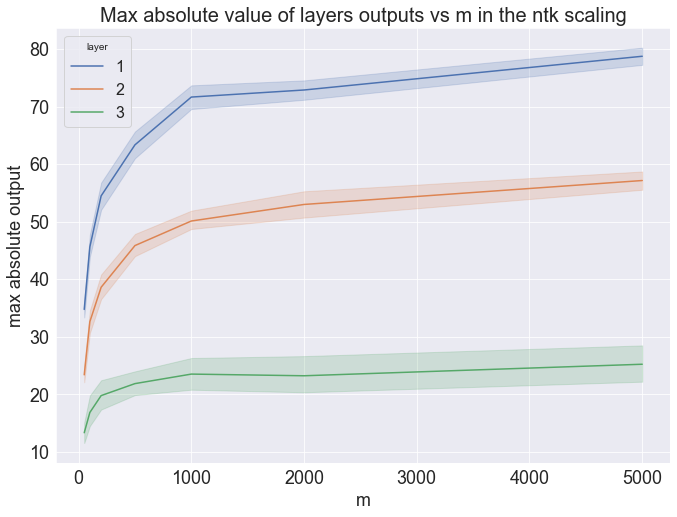

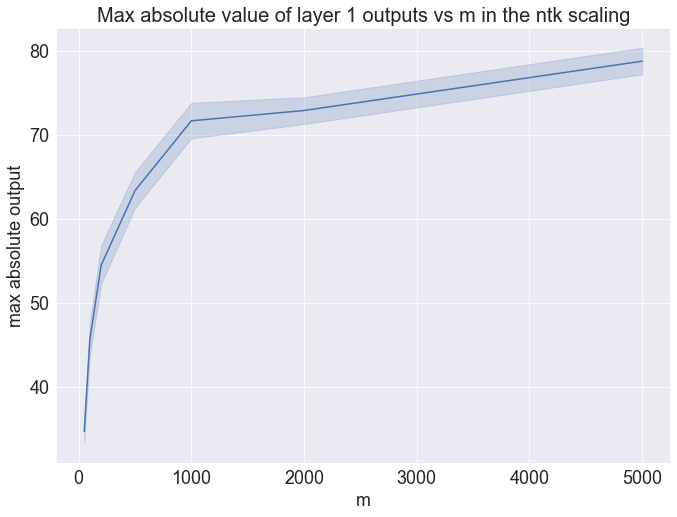

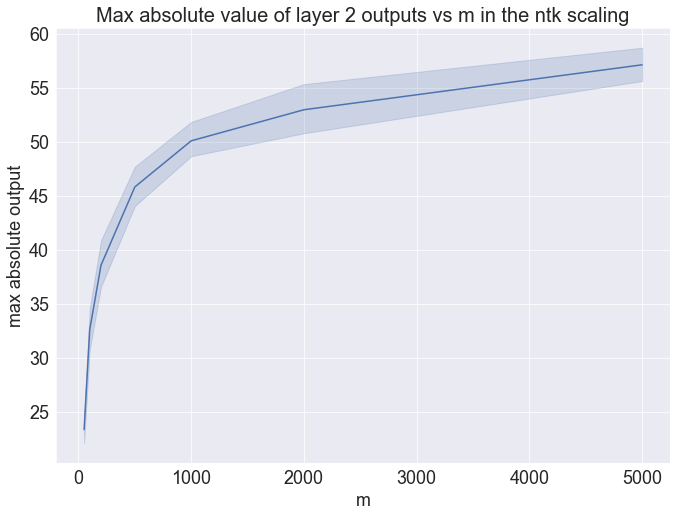

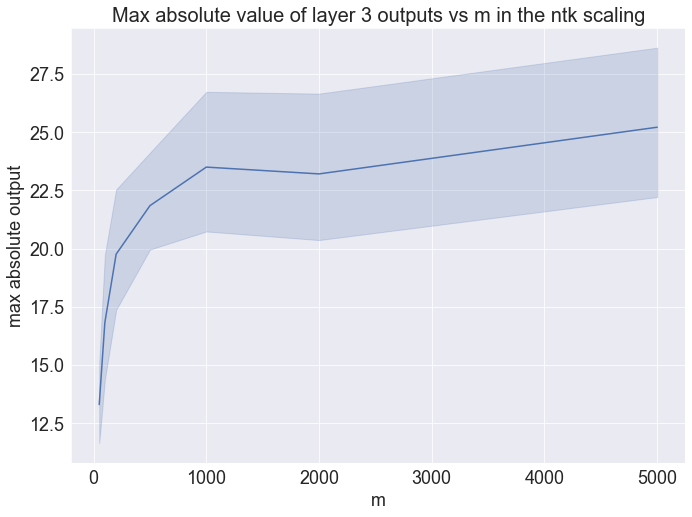

In [41]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init='sqrt')

### 4.2. Glorot normal initialization

In [42]:
init = 'glorot_normal'
init_params = {'gain': 1.0}
scale_init = 'sqrt'

#### 4.2.1 MF scaling

In [43]:
scaling = 'mf'

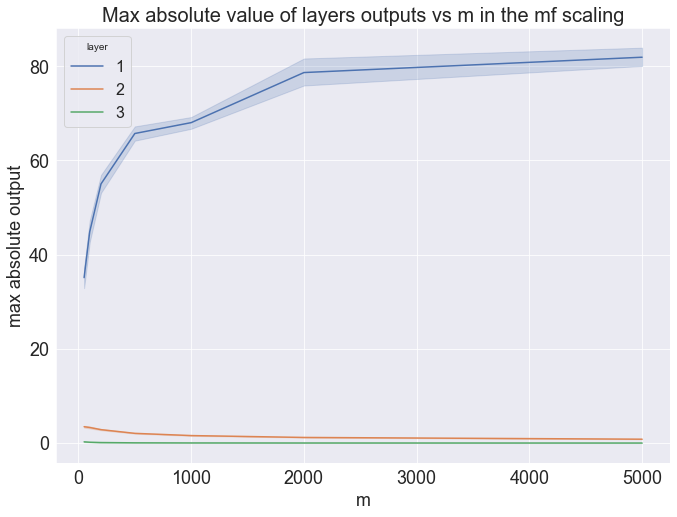

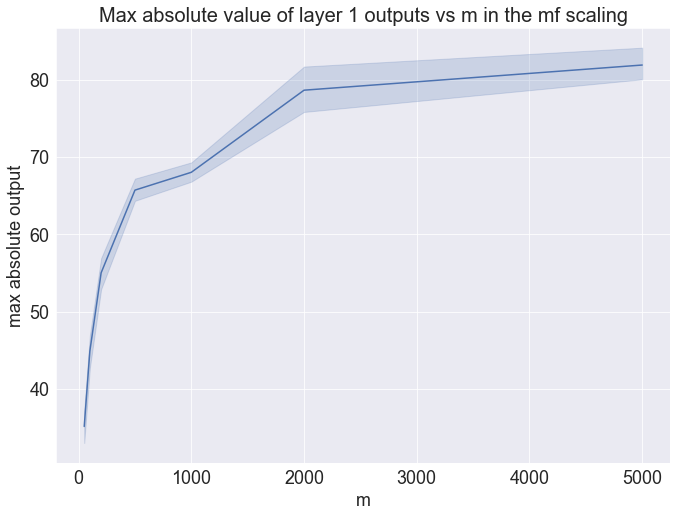

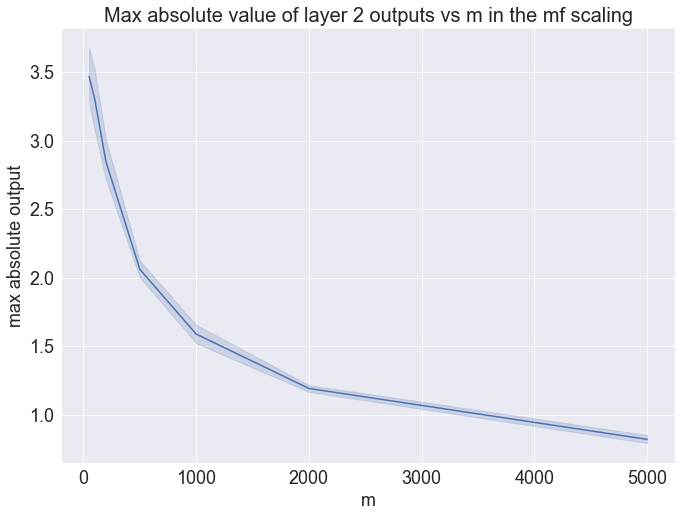

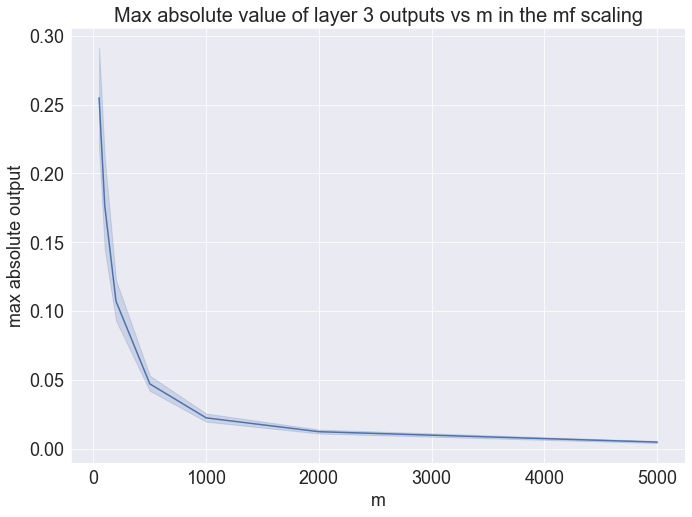

In [44]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init=scale_init)

#### 4.2.2 NTK scaling

In [45]:
scaling = 'ntk'

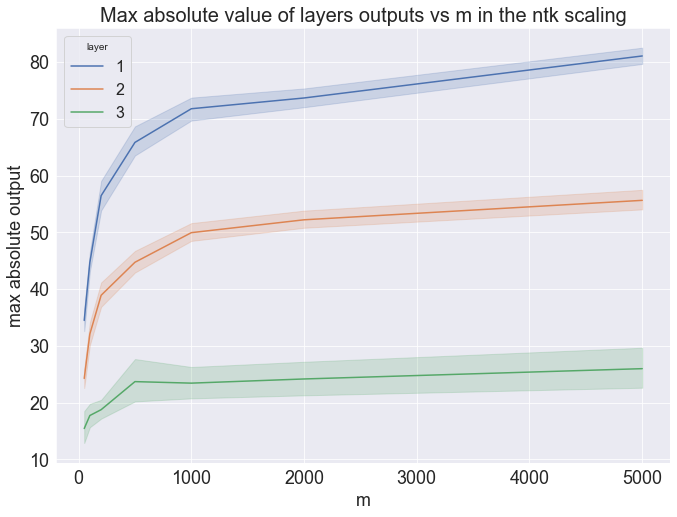

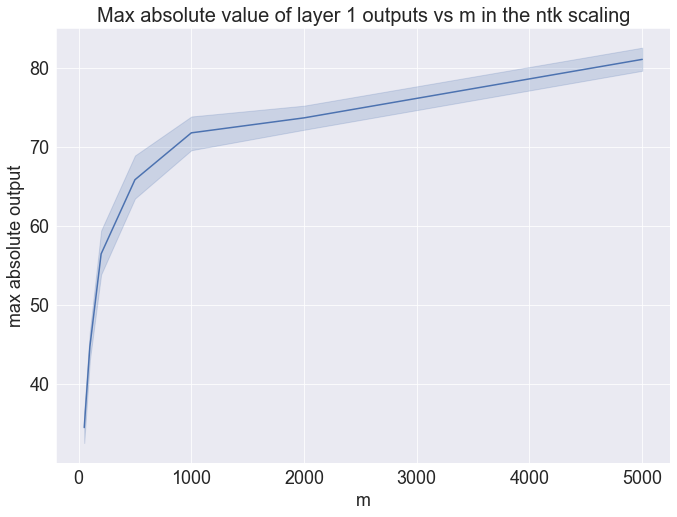

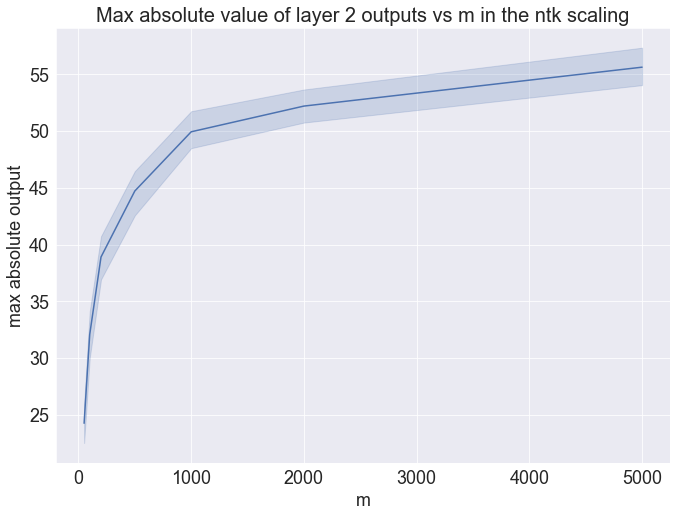

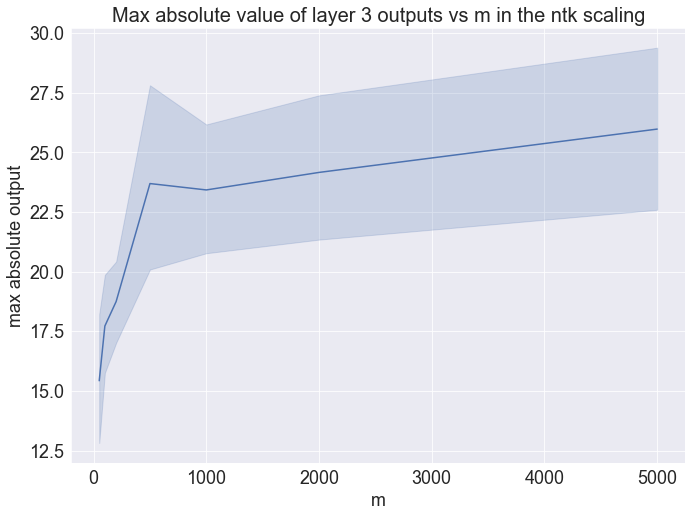

In [46]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init=scale_init)

## 5. i.i.id. dependent of layer size growing in $m$ with Glorot type init

### 5.1. Glorot Uniform initialization

In [47]:
init = 'glorot_uniform'
init_params = {'gain': 1.0}
scale_init = 'lin'

#### 5.1.1 MF scaling

In [48]:
scaling = 'mf'

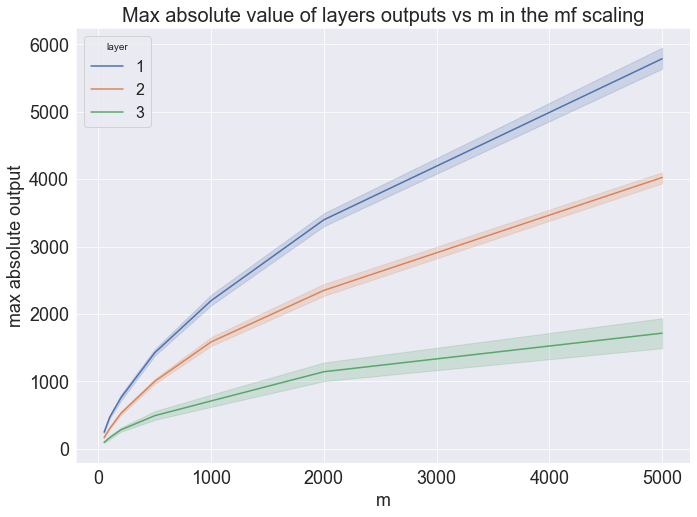

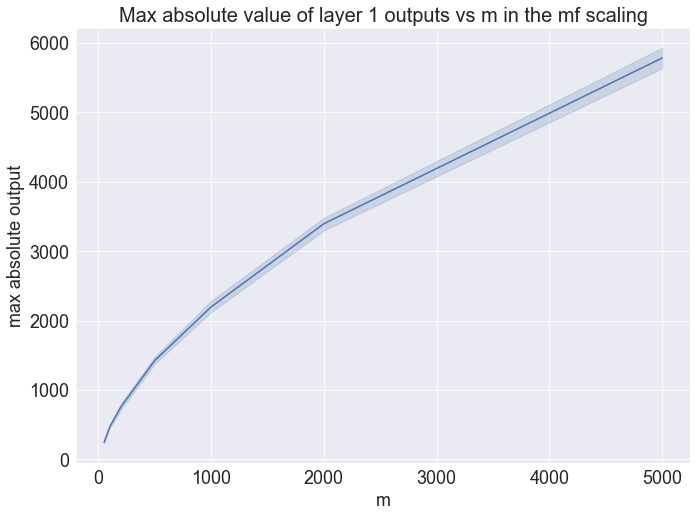

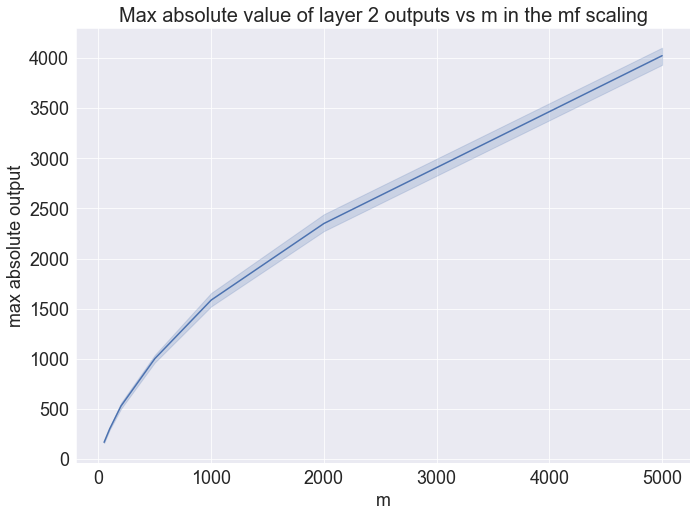

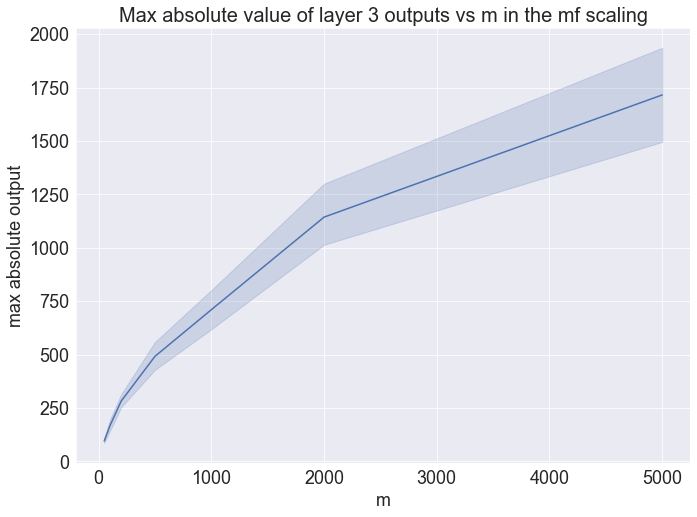

In [49]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init=scale_init)

### 5.2. Glorot Normal initialization

In [50]:
init = 'glorot_normal'
init_params = {'gain': 1.0}
scale_init = 'lin'

#### 5.2.1 MF scaling

In [51]:
scaling = 'mf'

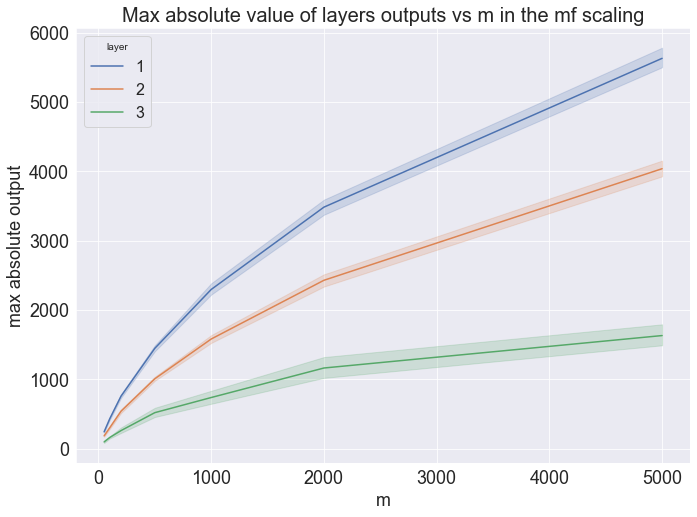

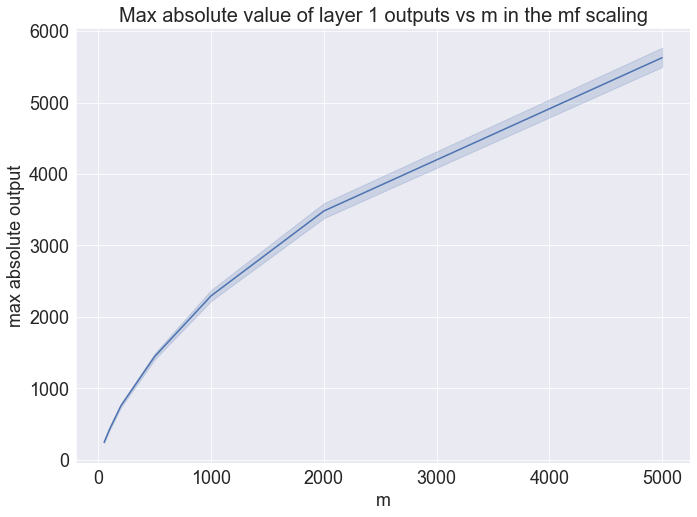

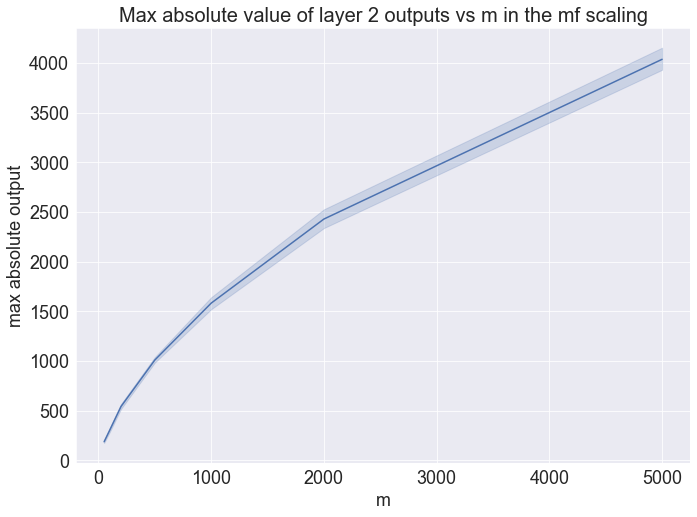

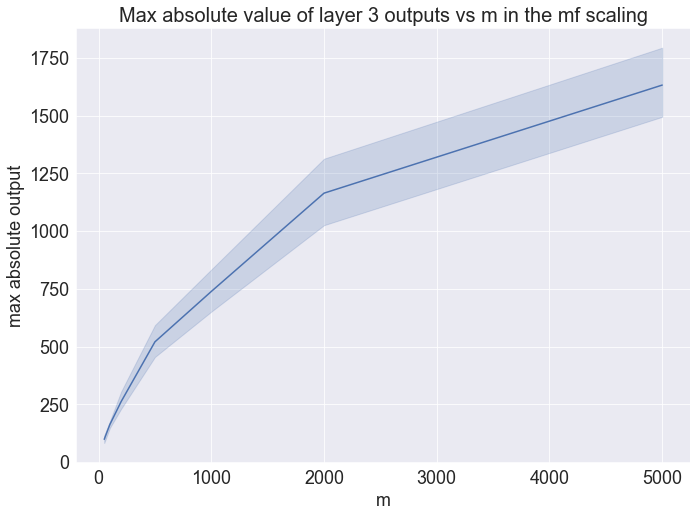

In [52]:
generate_outputs_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init=scale_init)

## 6. Studying the gradients norm per layer in the pure i.i.d. case

### 6.1. Uniform initialization

In [53]:
init = 'uniform'
init_params = {'a': -2.0, 'b': 2.0}

#### 6.1.1 MF scaling

In [54]:
scaling = 'mf'

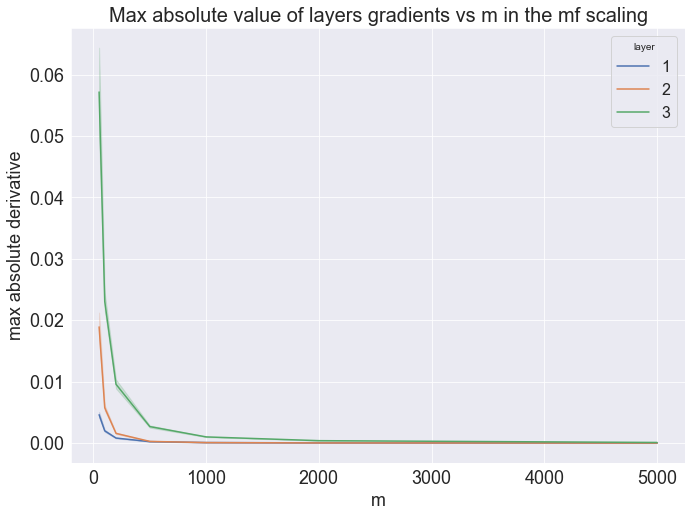

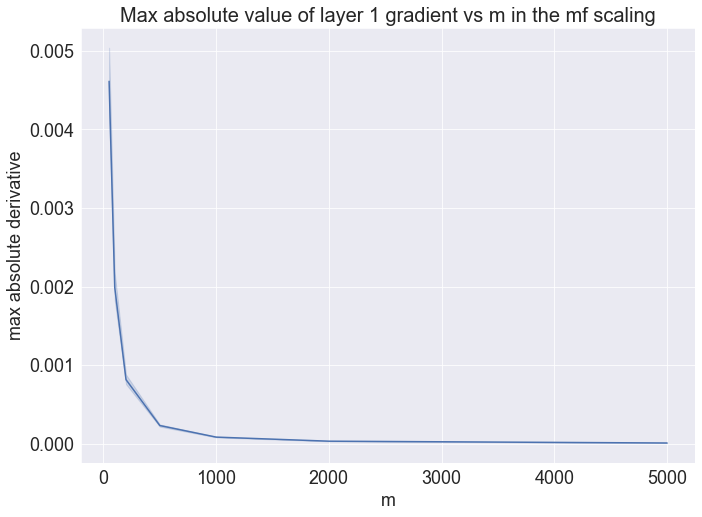

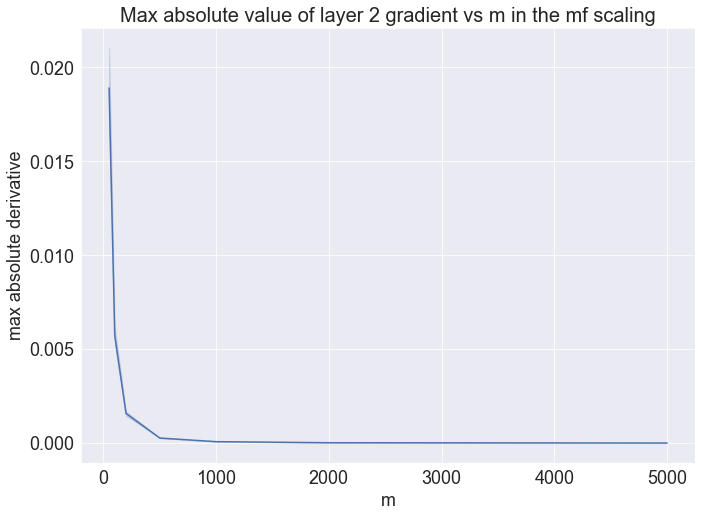

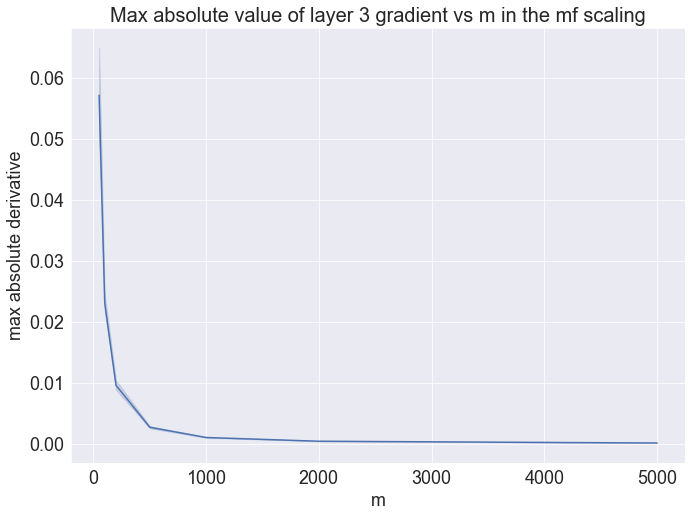

In [55]:
generate_gradients_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 6.1.2 NTK scaling

In [56]:
scaling = 'ntk'

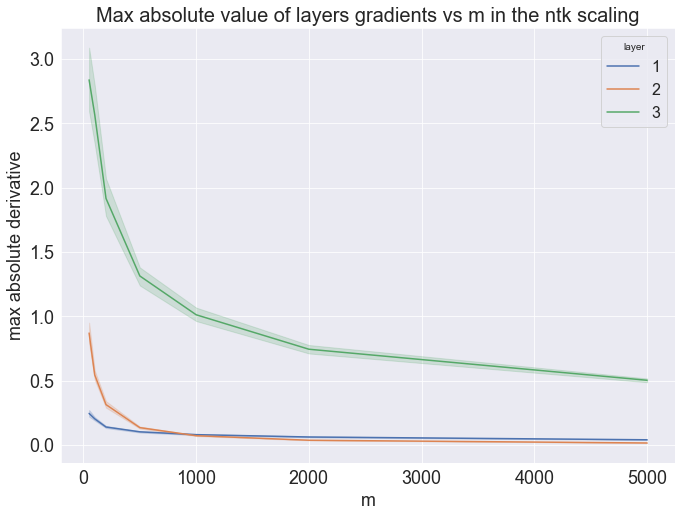

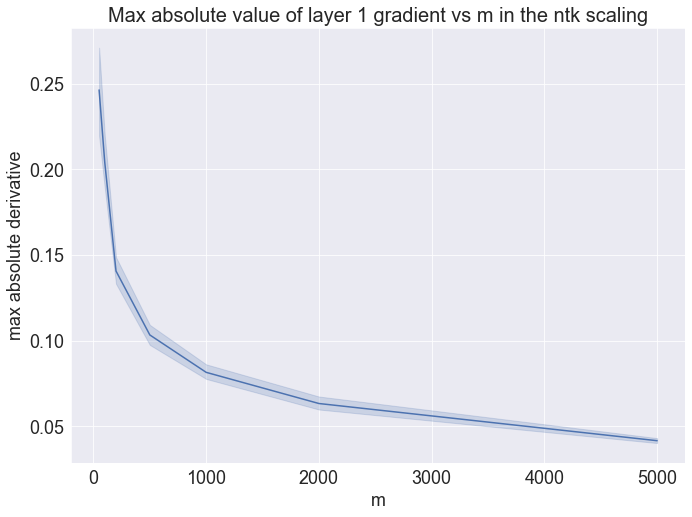

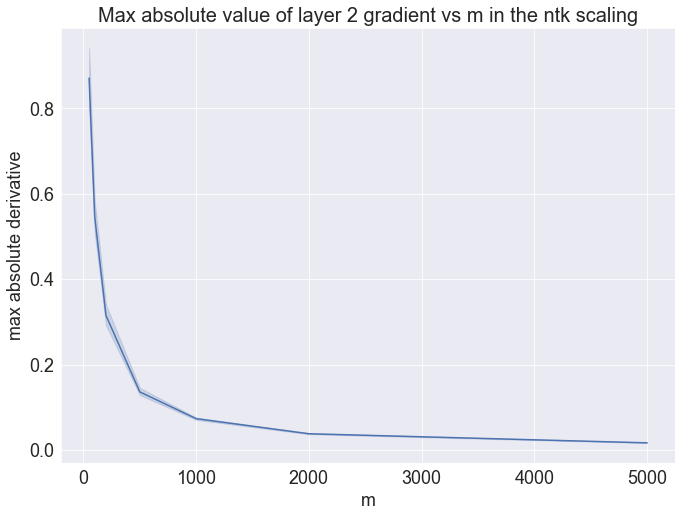

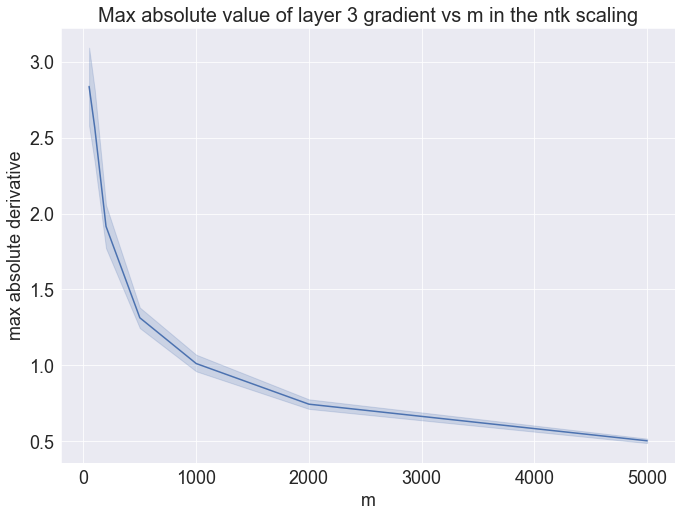

In [57]:
generate_gradients_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

### 6.2. Normal initialization

In [58]:
init = 'normal'
init_params = {'mean': 0.0, 'std': 2.0}

#### 6.2.1 MF scaling

In [59]:
scaling = 'mf'

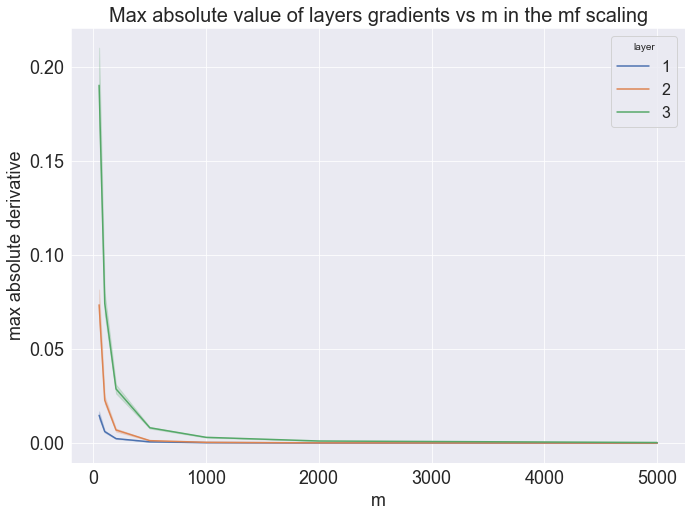

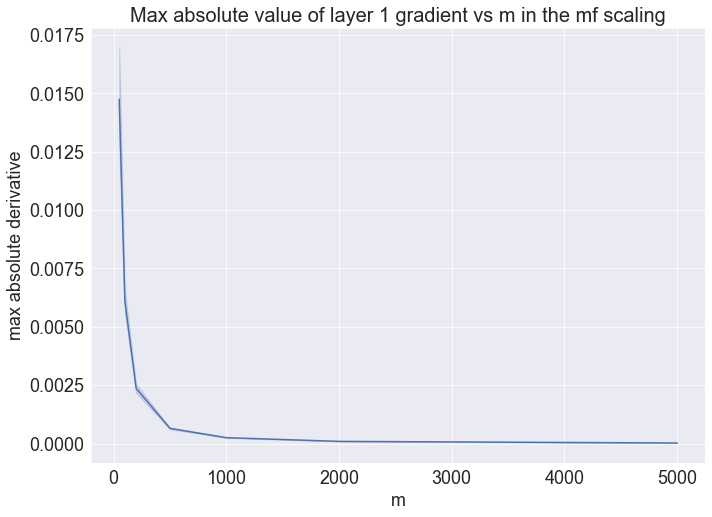

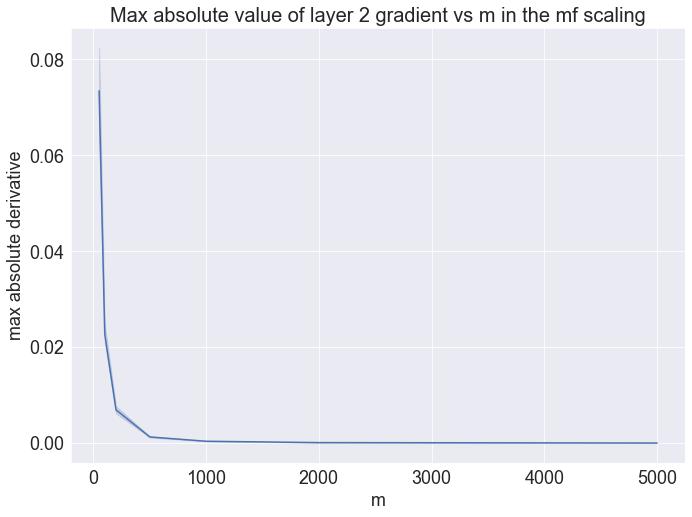

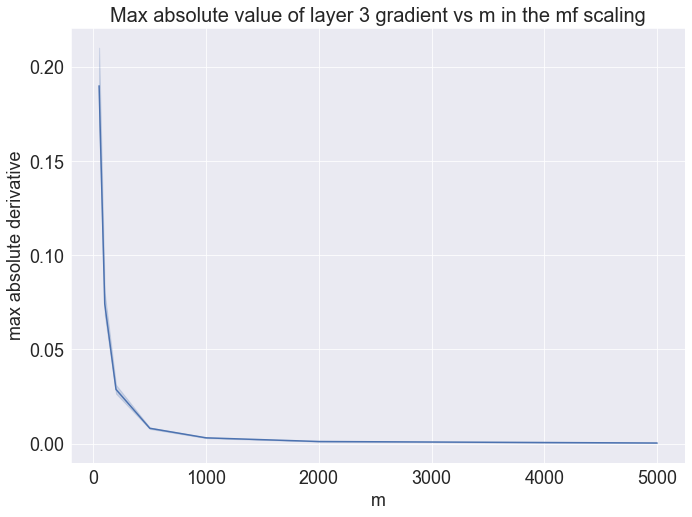

In [60]:
generate_gradients_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 6.2.2 NTK scaling

In [61]:
scaling = 'ntk'

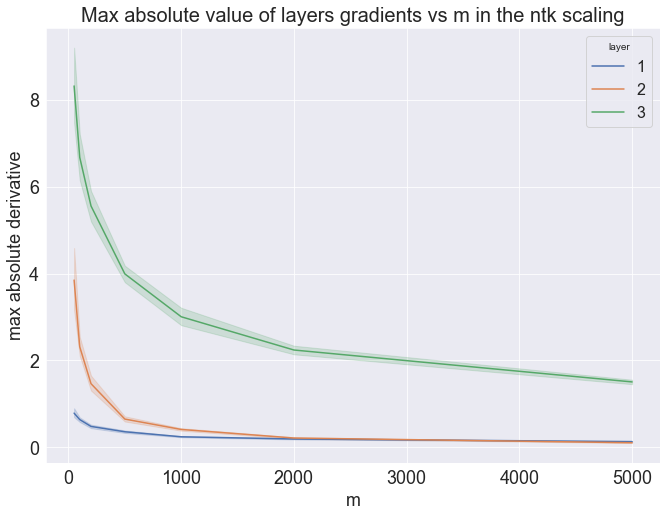

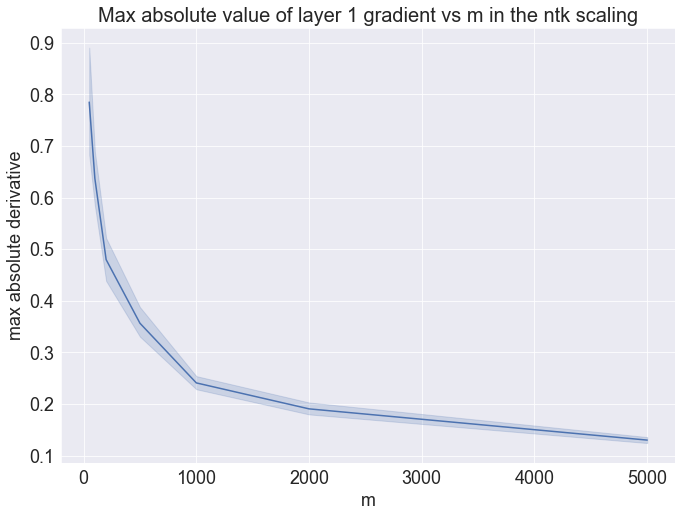

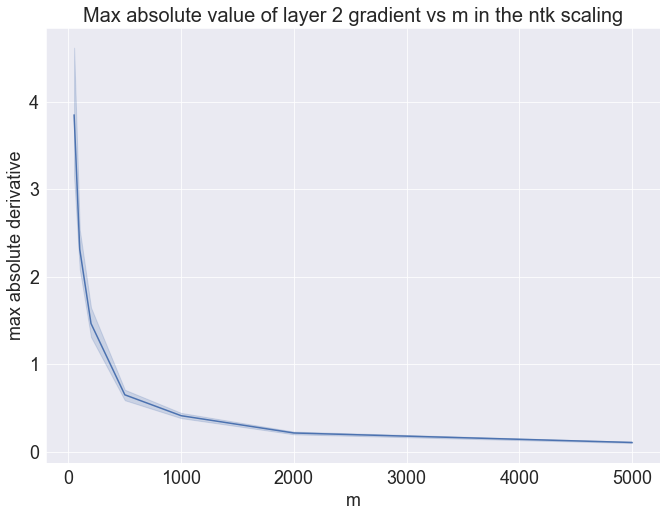

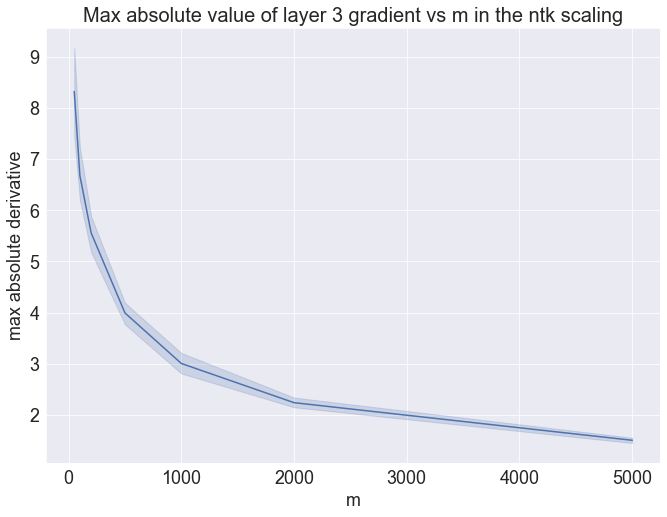

In [62]:
generate_gradients_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)